# SEMESTER PROJECT: USE YOUR BODY TO CONTROL A ROBOT - STUDY OF ROBOT MORPHOLOGY - Quadcopter

# Import 

In [141]:
import os,sys
sys.path.insert(1, os.path.join(sys.path[0], '..'))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import quaternion as quat
import quaternion_operations as quat_op

import HRI_mapping_add
import utils
#import helpers
import importlib
#importlib.reload(helpers)
#from helpers import compute_ea_df
import CalibrationDataset

import numpy as np
from numpy.fft import fft, ifft, fft2, ifft2, fftshift
from sklearn.cross_decomposition import CCA
from scipy import signal
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

settings = HRI_mapping_add.HRI_mapping_settings()
settings.used_body_parts=np.arange(1, 14)
settings.pll_mode = 'variance'

# Quadcopter - import data

In [142]:
df1 = pd.read_csv('drone_subject1_motive_mixed_period_8_amplitude_50_inst_9_2019_May_15_11_17_02AM.txt')
df2 = pd.read_csv('drone_subject2_motive_mixed_period_8_amplitude_50_inst_9_2019_May_15_12_36_43PM.txt')
df3 = pd.read_csv('drone_subject3_motive_mixed_period_8_amplitude_50_inst_9_2019_May_15_01_31_47PM.txt')
df4 = pd.read_csv('drone_subject4_motive_mixed_period_8_amplitude_50_inst_9_2019_May_15_01_53_24PM.txt')
df5 = pd.read_csv('drone_subject5_motive_mixed_period_8_amplitude_50_inst_9_2019_May_15_02_33_37PM.txt')
df6 = pd.read_csv('drone_subject6_motive_mixed_period_8_amplitude_50_inst_9_2019_May_15_03_01_19PM.txt')
df7 = pd.read_csv('drone_subject7_motive_mixed_period_8_amplitude_50_inst_9_2019_May_15_04_06_05PM.txt')
df8 = pd.read_csv('drone_subject8_motive_mixed_period_8_amplitude_50_inst_9_2019_May_15_04_55_35PM.txt')
df9 = pd.read_csv('drone_subject9_motive_mixed_period_8_amplitude_50_inst_9_2019_May_15_05_23_46PM.txt')
df10 = pd.read_csv('drone_subject11_motive_mixed_period_8_amplitude_50_inst_9_2019_May_20_02_27_16PM.txt')
df11 = pd.read_csv('drone_subject12_motive_mixed_period_8_amplitude_50_inst_9_2019_May_20_02_51_04PM.txt')
#df13 = pd.read_csv('drone_subject13_motive_mixed_period_8_amplitude_50_inst_9_2019_May_24_03_24_51PM.txt')
#df12 = pd.read_csv('drone_subject10_motive_mixed_period_8_amplitude_50_inst_9_2019_May_24_03_27_27PM.txt')
#df14 = pd.read_csv('drone_subject14_motive_mixed_period_8_amplitude_50_inst_9_2019_May_24_03_59_52PM.txt')
#df15 = pd.read_csv('drone_subject15_motive_mixed_period_8_amplitude_50_inst_9_2019_May_24_06_13_48PM.txt')

In [143]:
def remove_initial_bias_quaterions(limb, dataframe):

    global PI

    dataframe_out = pd.DataFrame.copy(dataframe)

    absolute = []
    relative = []

    str_abs_w = 'quat_w_' + str(limb)

    str_abs_x = 'quat_x_' + str(limb)

    str_abs_y = 'quat_y_' + str(limb)

    str_abs_z = 'quat_z_' + str(limb)

    """if DEBUG :
        plt.figure()
        plt.plot(dataframe['roll_' + str(limb)].values, label="old")
    """

    reference = np.quaternion(dataframe[str_abs_w].values[0], dataframe[str_abs_x].values[0], dataframe[str_abs_y].values[0], dataframe[str_abs_z].values[0])

    for i in range(0, dataframe.shape[0]):

        absolute.append(np.quaternion(dataframe[str_abs_w].values[i], dataframe[str_abs_x].values[i], dataframe[str_abs_y].values[i], dataframe[str_abs_z].values[i]))

        relative.append(absolute[-1]/reference)

        dataframe_out[str_abs_w].values[i] = relative[-1].w
        dataframe_out[str_abs_x].values[i] = relative[-1].x
        dataframe_out[str_abs_y].values[i] = relative[-1].y
        dataframe_out[str_abs_z].values[i] = relative[-1].z

    """if DEBUG :
        plt.plot(dataframe_out['roll_' + str(limb)].values, label="new")
        plt.grid()
        plt.legend()
        plt.title('angle ' + str(limb))
    """
    return dataframe_out

for i in range(11):
    df_in = eval('df'+str(i+1)) 
    df_out = remove_initial_bias_quaterions(settings.used_body_parts[0], df_in)
    for i in settings.used_body_parts[1:]:
        df_out = remove_initial_bias_quaterions(i, df_out)
    local_namespace = locals()
    local_namespace['df'+str(i+1)] = df_out
    


In [144]:
def relativize_angles(angles_to_correct, with_respect_to, dataframe, DEBUG = 0):
    
        dataframe_out = pd.DataFrame.copy(dataframe)
        
        reference = []
        absolute = []
        relative = []
        
        eul = []
        
        str_abs_w = 'quat_w_' + str(angles_to_correct)
        str_ref_w = 'quat_w_' + str(with_respect_to)
        
        str_abs_x = 'quat_x_' + str(angles_to_correct)
        str_ref_x = 'quat_x_' + str(with_respect_to)
        
        str_abs_y = 'quat_y_' + str(angles_to_correct)
        str_ref_y = 'quat_y_' + str(with_respect_to)
        
        str_abs_z = 'quat_z_' + str(angles_to_correct)
        str_ref_z = 'quat_z_' + str(with_respect_to)
        
        if DEBUG :
            plt.figure()
            plt.plot(dataframe['roll_' + str(angles_to_correct)].values, label="absolute")
            plt.plot(dataframe['roll_' + str(with_respect_to)].values, label="reference")
        
        for i in range(0, dataframe.shape[0]):
            reference.append(np.quaternion(dataframe[str_ref_w].values[i], dataframe[str_ref_x].values[i], dataframe[str_ref_y].values[i], dataframe[str_ref_z].values[i]))
            absolute.append(np.quaternion(dataframe[str_abs_w].values[i], dataframe[str_abs_x].values[i], dataframe[str_abs_y].values[i], dataframe[str_abs_z].values[i]))
            
            relative.append(absolute[-1]/reference[-1])
        
            dataframe_out[str_abs_w].values[i] = relative[-1].w
            dataframe_out[str_abs_x].values[i] = relative[-1].x
            dataframe_out[str_abs_y].values[i] = relative[-1].y
            dataframe_out[str_abs_z].values[i] = relative[-1].z
            
            
        if DEBUG :
            plt.plot(dataframe_out['roll_' + str(angles_to_correct)].values, label="relative")
            plt.grid()
            plt.legend()
            plt.title('angle ' + str(angles_to_correct))
            
        return dataframe_out
    
def _relativize_df(df_in):
    df_out = relativize_angles(9, 8, df_in)
    df_out = relativize_angles(8, 7, df_out)
    df_out = relativize_angles(7, 6, df_out)
    df_out = relativize_angles(6, 3, df_out)
    df_out = relativize_angles(13, 12, df_out)
    df_out = relativize_angles(12, 11, df_out)
    df_out = relativize_angles(11, 10, df_out)
    df_out = relativize_angles(10, 3, df_out)
    return df_out
    
for i in range(11):
    df = eval('df'+str(i+1)) 
    df = _relativize_df(df)
    local_namespace = locals()
    local_namespace['df'+str(i+1)] = df
    
    
    

In [135]:
def _compute_ea_df(df_in):

    df_out = _compute_euler_angles(settings.used_body_parts[0], df_in)
    
    for i in settings.used_body_parts[1:]:
        df_out = _compute_euler_angles(i, df_out)

    return df_out


def _compute_euler_angles(limb, dataframe, DEBUG = 0):
    
    global PI
    
    dataframe_out = pd.DataFrame.copy(dataframe)
    
    reference = []
    
    eul = []
    
    str_abs_w = 'quat_w_' + str(limb)
    
    str_abs_x = 'quat_x_' + str(limb)
    
    str_abs_y = 'quat_y_' + str(limb)
    
    str_abs_z = 'quat_z_' + str(limb)
    
    if DEBUG :
        plt.figure()
        plt.plot(dataframe['roll_' + str(limb)].values, label="old")
    
    for i in range(0, dataframe.shape[0]):
        
        
        reference.append(np.quaternion(dataframe[str_abs_w].values[i], dataframe[str_abs_x].values[i], dataframe[str_abs_y].values[i], dataframe[str_abs_z].values[i]))
        
        relative = reference[-1]
        
        eul.append(quat_op.Q2EA(np.array([relative.w, relative.x, relative.y, relative.z]), EulerOrder="zyx", ignoreAllChk=True)[0])
                       
        
    dataframe_out['roll_' + str(limb)] = pd.Series(utils.moving_average(np.array([x[2] for x in eul]), 1), index=dataframe_out.index)
    dataframe_out['pitch_' + str(limb)] = pd.Series(utils.moving_average(np.array([x[0] for x in eul]), 1), index=dataframe_out.index)
    dataframe_out['yaw_' + str(limb)] = pd.Series(utils.moving_average(np.array([x[1] for x in eul]), 1), index=dataframe_out.index)
        
    
    if DEBUG :
        plt.plot(dataframe_out['roll_' + str(limb)].values, label="new")
        plt.grid()
        plt.legend()
        plt.title('angle ' + str(limb))
        
    return dataframe_out


# Quaternion 

In [145]:
for i in range(11):
    df = eval('df'+str(i+1)) 
    df_euler = _compute_ea_df(df)
    local_namespace = locals()
    local_namespace['df'+str(i+1)] = df_euler
  

In [146]:
################ SHIFT THE SIGNALS ############ NOT USED ###################

#x: subject signal, y:Maneuver from Unity signal -> Find how much to shift the signals
def cross_correlation_using_fft(x, y):
    f1 = fft(x)
    f2 = fft(np.flipud(y))
    cc = np.real(ifft(f1 * f2))
    return fftshift(cc)
# Shift difference between the two signals
def compute_shift(x, y):
    assert len(x) == len(y)
    c = cross_correlation_using_fft(x, y)
    assert len(c) == len(x)
    zero_index = int(len(x) / 2) - 1
    shift = zero_index - np.argmax(c)
    return shift

# Select Regions of interest

In [147]:
for i in range(11):
    df = eval('df'+str(i+1)) 
    df_roll = df[df.input1 != 0.0]
    df_pitch = df[df.input2 != 0.0]
    df_thrust = df[df.input3 != 0.0]
    df_yaw = df[df.input4 != 0.0]
    local_namespace = locals()
    local_namespace['df_pitch'+str(i+1)] = df_pitch
    local_namespace['df_roll'+str(i+1)] = df_roll
    local_namespace['df_thrust'+str(i+1)] = df_thrust
    local_namespace['df_yaw'+str(i+1)] = df_yaw
    

# Normalize 

In [239]:
def standardization(dataset):
    dtypes = list(zip(dataset.dtypes.index, map(str, dataset.dtypes)))
    # Normalize numeric columns.
    for column, dtype in dtypes:
        if dtype == 'float64':
            #if not column.__contains__('input'):
            dataset[column] -= dataset[column].mean()
            dataset[column] /= dataset[column].std()
    return dataset

for i in range(11):
    df_roll = eval('df_roll'+str(i+1)) 
    df_roll = standardization(df_roll)
    local_namespace['df_roll_pca'+str(i+1)] = df_roll
    
    df_pitch = eval('df_pitch'+str(i+1)) 
    df_pitch = standardization(df_pitch)
    local_namespace['df_pitch_pca'+str(i+1)] = df_pitch
    
    df_thrust = eval('df_thrust'+str(i+1)) 
    df_thrust = standardization(df_thrust)
    local_namespace['df_thrust_pca'+str(i+1)] = df_thrust
    
    df_yaw = eval('df_yaw'+str(i+1)) 
    df_yaw = standardization(df_yaw)
    local_namespace['df_yaw_pca'+str(i+1)] = df_yaw
    

/Users/philippspiess/anaconda3/envs/HRI_mapping/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/Users/philippspiess/anaconda3/envs/HRI_mapping/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


# Plot to visualize


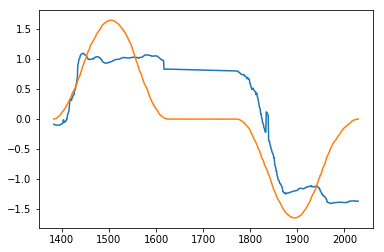

In [240]:
for i in range(1):
    str_abs_w = 'pitch_' + str(i+1)
    plt.plot(df_thrust1[str_abs_w])
    plt.plot(df_thrust1['input3'])
    plt.show()


# CORRELATION eval 

In [155]:
#roll

threshold=0.7
motion = ['roll_','pitch_', 'yaw_']
for i in range(11):
    df = eval('df_roll'+str(i+1))
    dft=df
    Y = dft['input1']
    for j in range(13):
        for k in range(3):
            X = dft[motion[k] + str(j+1)] #here only try the position
            #local_namespace = locals()
            Xcorr = np.corrcoef(np.transpose(X), np.transpose(Y))
            Xcorr = Xcorr[:,0]
            if abs(Xcorr[1]) < threshold:
                dft = dft.drop(motion[k]+str(j+1), axis=1)
    local_namespace['df_roll_select'+str(i+1)] = dft

In [159]:
#roll

motion = ['roll_','pitch_', 'yaw_']
table = []
for j in range(13):
    for k in range(3):
        table.append(motion[k] + str(j+1))

#count how many people use the markers roll/pitch/yaw
counts = np.zeros(len(table))
for i in range(11):
    df = eval('df_roll_select'+str(i+1)) ####CHANGE HERE
    for j in range(13):
        for k in range(3):
            marker = [motion[k] + str(j+1)]
            col = [*df]
            counts[3*j + k] += col.count(marker[0])
    
#PICK the most among subjects
for i in range(len(counts)):
    if counts[i] > 6:
        print(table[i], counts[i]) 

pitch_4 7.0
pitch_5 8.0
yaw_5 7.0
yaw_12 7.0


In [169]:
#pitch

threshold=0.8
motion = ['roll_','pitch_', 'yaw_']
for i in range(11):
    df = eval('df_pitch'+str(i+1))
    dft=df
    Y = dft['input2']
    for j in range(13):
        for k in range(3):
            X = dft[motion[k] + str(j+1)] #here only try the position
            #local_namespace = locals()
            Xcorr = np.corrcoef(np.transpose(X), np.transpose(Y))
            Xcorr = Xcorr[:,0]
            if abs(Xcorr[1]) < threshold:
                dft = dft.drop(motion[k]+str(j+1), axis=1)
    local_namespace['df_pitch_select'+str(i+1)] = dft

In [172]:
#pitch

motion = ['roll_','pitch_', 'yaw_']
table = []
for j in range(13):
    for k in range(3):
        table.append(motion[k] + str(j+1))

#count how many people use the markers roll/pitch/yaw
counts = np.zeros(len(table))
for i in range(11):
    df = eval('df_pitch_select'+str(i+1)) ####CHANGE HERE
    for j in range(13):
        for k in range(3):
            marker = [motion[k] + str(j+1)]
            col = [*df]
            counts[3*j + k] += col.count(marker[0])
    
#PICK the most among subjects
for i in range(len(counts)):
    if counts[i] > 4:
        print(table[i], counts[i])
    
        

roll_2 5.0
roll_4 5.0


In [166]:
#yaw

threshold=0.8
motion = ['roll_','pitch_', 'yaw_']
for i in range(11):
    df = eval('df_yaw'+str(i+1))
    dft=df
    Y = dft['input4']
    for j in range(13):
        for k in range(3):
            X = dft[motion[k] + str(j+1)] #here only try the position
            #local_namespace = locals()
            Xcorr = np.corrcoef(np.transpose(X), np.transpose(Y))
            Xcorr = Xcorr[:,0]
            if abs(Xcorr[1]) < threshold:
                dft = dft.drop(motion[k]+str(j+1), axis=1)
    local_namespace['df_yaw_select'+str(i+1)] = dft

In [168]:
#yaw

motion = ['roll_','pitch_', 'yaw_']
table = []
for j in range(13):
    for k in range(3):
        table.append(motion[k] + str(j+1))

#count how many people use the markers roll/pitch/yaw
counts = np.zeros(len(table))
for i in range(11):
    df = eval('df_yaw_select'+str(i+1)) ####CHANGE HERE
    for j in range(13):
        for k in range(3):
            marker = [motion[k] + str(j+1)]
            col = [*df]
            counts[3*j + k] += col.count(marker[0])
    
#PICK the most among subjects
for i in range(len(counts)):
    if counts[i] > 5:
        print(table[i], counts[i])

roll_3 8.0
roll_5 10.0
yaw_7 6.0


# Feature extraction for PCA

In [180]:
#two values in thurst action

dataset=np.asarray(df_thrust1['input3'])
dataset=dataset[0:480]
for i in range(11):
    df = eval('df_thrust'+str(i+1)) ###CHANGE HERE
    for column in df:
        if column == 'roll_8':
            a = np.asarray(df[column])
            print(a.shape)
            a = a[0:480]
            dataset = np.c_[dataset, a]
dataset_pca = np.delete(dataset, (0), axis=1)
dataset_pca = np.transpose(dataset_pca)
dataset = np.transpose(dataset)
orig = dataset[0]


(500,)
(578,)
(537,)
(560,)
(482,)
(504,)
(566,)
(586,)
(601,)
(658,)
(676,)


# PCA and CLUSTERING - (skip for rover)

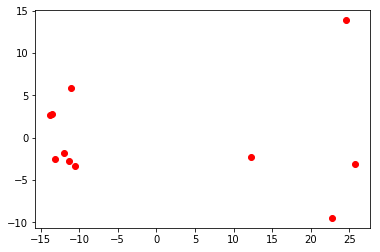

In [181]:
#dataset = np.transpose(dataset)
pca = PCA(n_components=2)
pca.fit(dataset_pca)
X_pca=pca.transform(dataset_pca)
plt.plot(X_pca[:,0],X_pca[:,1],'ro')
plt.show()

[0 1 0 0 1 0 0 0 0 1 1]


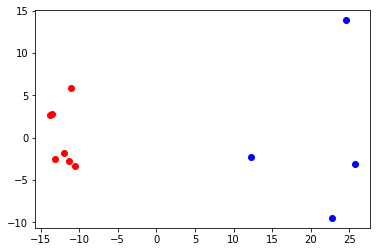

In [182]:
#explained = pca.explained_variance_ratio_
kmeans = KMeans(n_clusters=2, random_state=0).fit(X_pca) ###number of cluster
labels = kmeans.labels_
centers = kmeans.cluster_centers_
print(labels)
plt.plot(X_pca[np.where(labels ==0),0],X_pca[np.where(labels ==0),1],'ro')
plt.plot(X_pca[np.where(labels ==1),0],X_pca[np.where(labels ==1),1],'bo')
plt.show()

/Users/philippspiess/anaconda3/envs/HRI_mapping/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/Users/philippspiess/anaconda3/envs/HRI_mapping/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


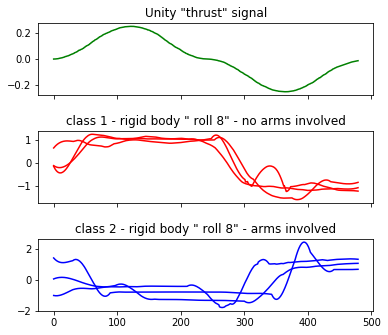

In [241]:
Y = orig
class1 = dataset_pca[np.where(labels ==0)]
class2 = dataset_pca[np.where(labels ==1)]
mean1 = np.mean(class1)
mean2 = np.mean(class2)

#VISUALIZE THE DIFFERENCE
fig, (ax_orig, ax_class1, ax_class2) = plt.subplots(3, 1, sharex=True)
plt.subplots_adjust(left=None, bottom=0.001, right=None, top=1, wspace=None, hspace=0.5)
ax_orig.plot(Y, 'g')
ax_orig.set_title('Unity "thrust" signal')
class1[0] = signal.savgol_filter(class1[0], 61, 3)
class1[1] = signal.savgol_filter(class1[1], 61, 3)
class1[2] = signal.savgol_filter(class1[2], 61, 3)
ax_class1.plot(class1[0], 'r')
ax_class1.plot(class1[1], 'r')
ax_class1.plot(class1[2], 'r')
ax_class1.set_title('class 1 - rigid body " roll 8" - no arms involved')
class2[0] = signal.savgol_filter(class2[0], 61, 3)
class2[1] = signal.savgol_filter(class2[1], 61, 3)
class2[2] = signal.savgol_filter(class2[2], 61, 3)
ax_class2.plot(class2[0], 'b')
ax_class2.plot(class2[1],'b')
ax_class2.plot(class2[2],'b')
ax_class2.set_title('class 2 - rigid body " roll 8" - arms involved')
fig.show()

In [242]:
#thrust ---> with corresponding labels !

threshold=0.7
motion = ['roll_','pitch_', 'yaw_']
for i in group1:
    df = eval('df_thrust'+str(i+1))
    dft=df
    Y = dft['input3']
    for j in range(13):
        for k in range(3):
            X = dft[motion[k] + str(j+1)] #here only try the position
            #local_namespace = locals()
            Xcorr = np.corrcoef(np.transpose(X), np.transpose(Y))
            Xcorr = Xcorr[:,0]
            if Xcorr[1] < threshold:
                dft = dft.drop(motion[k]+str(j+1), axis=1)
    local_namespace['df_thrust_select'+str(i+1)] = dft
    motion = ['roll_','pitch_', 'yaw_']
table = []
for j in range(13):
    for k in range(3):
        table.append(motion[k] + str(j+1))

#count how many people use the markers roll/pitch/yaw
counts = np.zeros(len(table))
for i in group1:
    df = eval('df_thrust_select'+str(i+1)) ####CHANGE HERE
    for j in range(13):
        for k in range(3):
            marker = [motion[k] + str(j+1)]
            col = [*df]
            counts[3*j + k] += col.count(marker[0])
    
#PICK the most among subjects
for i in range(len(counts)):
    if counts[i] > 3:
        print(table[i], counts[i])

pitch_7 5.0
roll_8 6.0
yaw_11 4.0


# Regression

/Users/philippspiess/anaconda3/envs/HRI_mapping/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


0.12215376446790448
0.44105466912268115
0.14710645764695976
0.18771053027727277
0.20362070435842075
0.23884218146708242
0.4126986995944948
0.2162046954654253
0.1698408374245726
0.6630700854313067


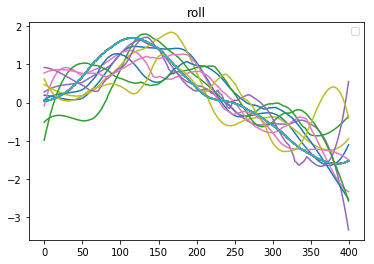

In [254]:
###roll

from sklearn.linear_model import LinearRegression
marker_list=['yaw_5', 'pitch_4', 'pitch_5']

for i in range(10):
    data_reg=np.asarray(df_roll1['input1'])
    data_reg=data_reg[0:400]
    for k in range(3):
        X=[]
        df_roll= eval('df_roll'+str(i+1)) 
        for column in df_roll:
            if column == marker_list[k]:
                X = np.asarray(df_roll[column])
                X = X[0:400]
                X = signal.savgol_filter(X, 101, 3)
                data_reg = np.c_[data_reg, X]
    model = LinearRegression()
    X = data_reg[:,1:4]
    Y = data_reg[:,0]
    model.fit(X, Y)
    y_pred_filter =  model.predict(X)
    plt.title('roll')
    plt.plot(y_pred_filter)
    plt.plot(Y)
    plt.legend()
    #plt.show()
    print(mean_squared_error(Y, y_pred_filter))

/Users/philippspiess/anaconda3/envs/HRI_mapping/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


0.17717027237553692
0.2133943744643631
0.18733792942548638
0.3362558682412556
0.17282174252229718
0.42505470591470407
0.4984615462739645
0.3942068475922202
0.33698458914663126
0.6390423065687179


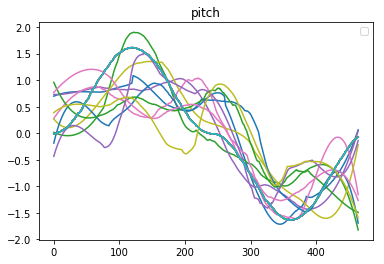

In [260]:
### pitch

from sklearn.linear_model import LinearRegression
marker_list=['roll_1', 'roll_2', 'roll_4']


for i in range(10):
    data_reg=np.asarray(df_pitch1['input2'])
    data_reg=data_reg[0:465]
    for k in range(3):
        X=[]
        df_pitch= eval('df_pitch'+str(i+1)) 
        for column in df_pitch:
            if column == marker_list[k]:
                X = np.asarray(df_pitch[column])
                X = X[0:465]
                X = signal.savgol_filter(X, 141, 3)
                data_reg = np.c_[data_reg, X]
    model = LinearRegression()
    X = data_reg[:,1:4]
    Y = data_reg[:,0]
    model.fit(X, Y)
    y_pred_filter =  model.predict(X)
    plt.title('pitch')
    plt.plot(y_pred_filter)
    plt.plot(Y)
    plt.legend()
    print(mean_squared_error(Y, y_pred_filter))

0.24673279214831734
0.32979776852444875
0.22528532602260126
0.45757679819899283
0.7088454379794207
0.5449322142906463
0.44379019534949027
0.2317210395004447
0.2548996294482229
0.7154095767868403
0.5058047274255496


/Users/philippspiess/anaconda3/envs/HRI_mapping/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


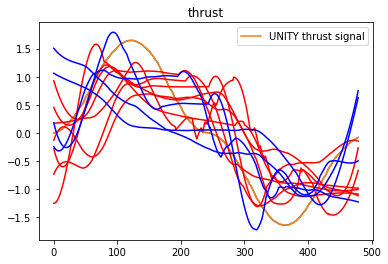

In [276]:
### thrust 1
group1 = [0,2,5,6,7,8,9] #no arms
group2 = [1,4,10,11] #arms
from sklearn.linear_model import LinearRegression
marker_list=['pitch_4', 'pitch_5', 'yaw_7']
plt.title('thrust')
plt.plot(Y)
plt.plot(Y, label="UNITY thrust signal")
plt.legend()

for i in group1:
    data_reg=np.asarray(df_thrust1['input3'])
    data_reg=data_reg[0:480]
    for k in range(3):
        X=[]
        df_thrust= eval('df_thrust'+str(i+1)) 
        for column in df_thrust:
            if column == marker_list[k]:
                X = np.asarray(df_thrust[column])
                X = X[0:480]
                X = signal.savgol_filter(X, 91, 3)
                data_reg = np.c_[data_reg, X]
    model = LinearRegression()
    X = data_reg[:,1:4]
    Y = data_reg[:,0]
    model.fit(X, Y)
    y_pred_filter =  model.predict(X)
    print(mean_squared_error(Y, y_pred_filter))
    plt.plot(y_pred_filter, 'r', label="regression class 1")

for i in group2:
    marker_list=['pitch_7', 'roll_8', 'yaw_11']
    data_reg1=np.asarray(df_thrust1['input3'])
    data_reg1=data_reg1[0:480]
    for k in range(3):
        X=[]
        df_thrust= eval('df_thrust'+str(i+1)) 
        for column in df_thrust:
            if column == marker_list[k]:
                X = np.asarray(df_thrust[column])
                X = X[0:480]
                X = signal.savgol_filter(X, 91, 3)
                data_reg1 = np.c_[data_reg1, X]
    model = LinearRegression()
    X = data_reg1[:,1:4]
    Y = data_reg1[:,0]
    model.fit(X, Y)
    y_pred_filter1 =  model.predict(X)
    print(mean_squared_error(Y, y_pred_filter1))
    plt.plot(y_pred_filter1,'b', label="regression class 2")

plt.show()

/Users/philippspiess/anaconda3/envs/HRI_mapping/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


0.12713080154196427
0.5378785009070869
0.15708075103309888
0.20625541225220484
0.1707415672132083
0.10877425250805622
0.19520706681764693
0.37856877605975975
0.29261761296374095
0.5341221743160566


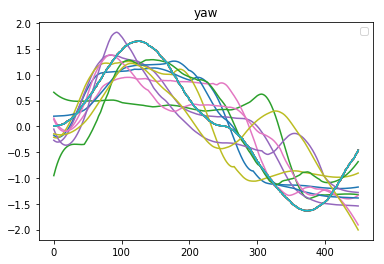

In [266]:
### yaw

from sklearn.linear_model import LinearRegression
marker_list=['roll_3', 'roll_5', 'yaw_7']

for i in range(10):
    data_reg=np.asarray(df_yaw1['input4'])
    data_reg=data_reg[0:450]
    for k in range(3):
        X=[]
        df_yaw= eval('df_yaw'+str(i+1)) 
        for column in df_yaw:
            if column == marker_list[k]:
                X = np.asarray(df_yaw[column])
                X = X[0:450]
                data_reg = np.c_[data_reg, X]
    model = LinearRegression()
    X = data_reg[:,1:4]
    Y = data_reg[:,0]
    model.fit(X, Y)
    y_pred =  model.predict(X)
    y_pred_filter = signal.savgol_filter(y_pred, 91, 3)
    plt.title('yaw')
    plt.plot(y_pred_filter)
    plt.plot(Y)
    plt.legend()
    print(mean_squared_error(Y, y_pred_filter))